### Importing The Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
fold = KFold(n_splits=10)
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
### Loading Of Datasets

In [3]:
train = pd.read_csv("./data/Housing_dataset_train.csv")
print(f"Train dataset has shape of: {train.shape}")

test = pd.read_csv("./data/Housing_dataset_test.csv")
print(f"Test dataset has shape of: {test.shape}")

submission = pd.read_csv("./data/Sample_submission.csv")

Train dataset has shape of: (14000, 7)
Test dataset has shape of: (6000, 6)


In [4]:
train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.00000,2.00000,1.00000,1149999.56500
1,2748,Ondo,Apartment,NaN,2.00000,4.00000,1672416.68900
2,9261,Ekiti,NaN,7.00000,5.00000,NaN,3364799.81400
3,2224,Anambra,Detached duplex,5.00000,2.00000,4.00000,2410306.75600
4,10300,Kogi,Terrace duplex,NaN,5.00000,6.00000,2600700.89800


In [5]:
test.head()

,ID,loc,title,bedroom,bathroom,parking_space
0,845,Kano,Penthouse,4,1,2
1,1924,Adamawa,Apartment,2,2,4
2,10718,Adamawa,Bungalow,2,7,2
3,12076,Lagos,Mansion,9,5,2
4,12254,Gombe,Semi-detached duplex,5,6,1


In [6]:
submission.head()

,ID
0,845
1,1924
2,10718
3,12076
4,12254


## Explorativre Data Analysis(EDA)

In [7]:
# Checking for missing features
train.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [8]:
test.isnull().sum()

ID               0
loc              0
title            0
bedroom          0
bathroom         0
parking_space    0
dtype: int64

### Data Visualization

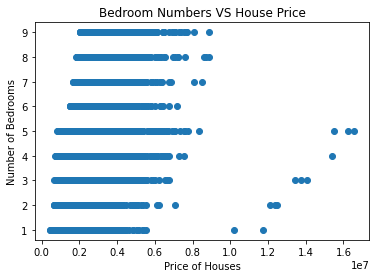

In [9]:
#Effect of Bedrooms Number on Price

plt.scatter(train["price"], train["bedroom"])
plt.xlabel("Price of Houses")
plt.ylabel("Number of Bedrooms")
plt.title("Bedroom Numbers VS House Price");

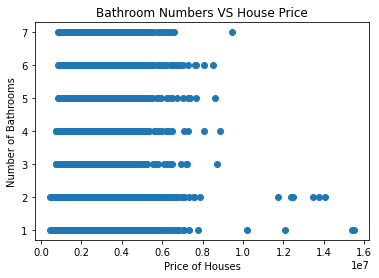

In [10]:
#Effect of Bathrooms Number on Price

plt.scatter(train["price"], train["bathroom"])
plt.xlabel("Price of Houses")
plt.ylabel("Number of Bathrooms")
plt.title("Bathroom Numbers VS House Price");

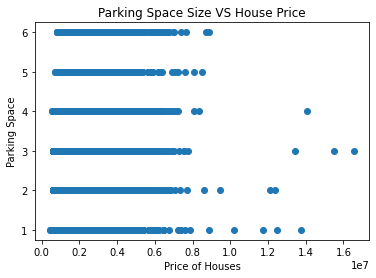

In [11]:
#Effect of Parking Space size on Price

plt.scatter(train["price"], train["parking_space"])
plt.xlabel("Price of Houses")
plt.ylabel("Parking Space")
plt.title("Parking Space Size VS House Price");

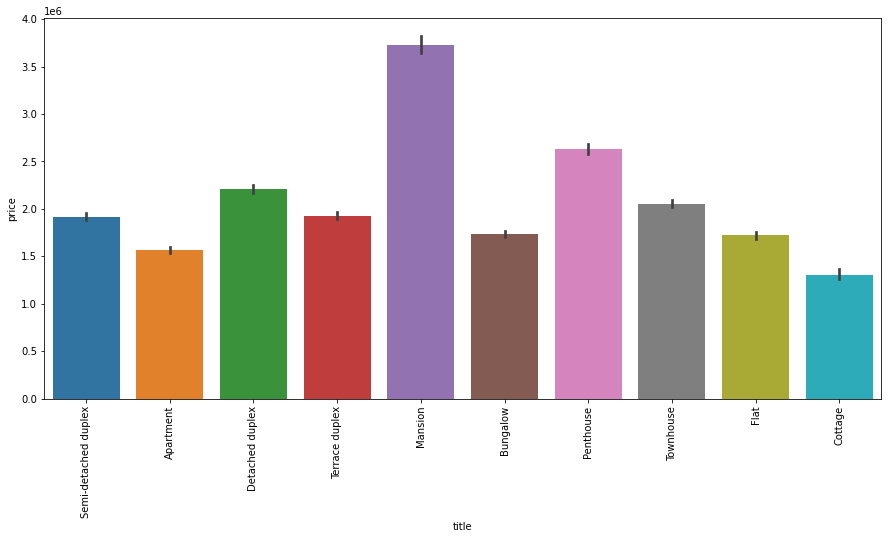

In [12]:
# Visualizing 'title column so see if it has effect on the target'

plt.figure(figsize=(15,7))
sns.barplot(x = train['title'],y = train['price'])
plt.xticks(rotation = 'vertical')
plt.show()

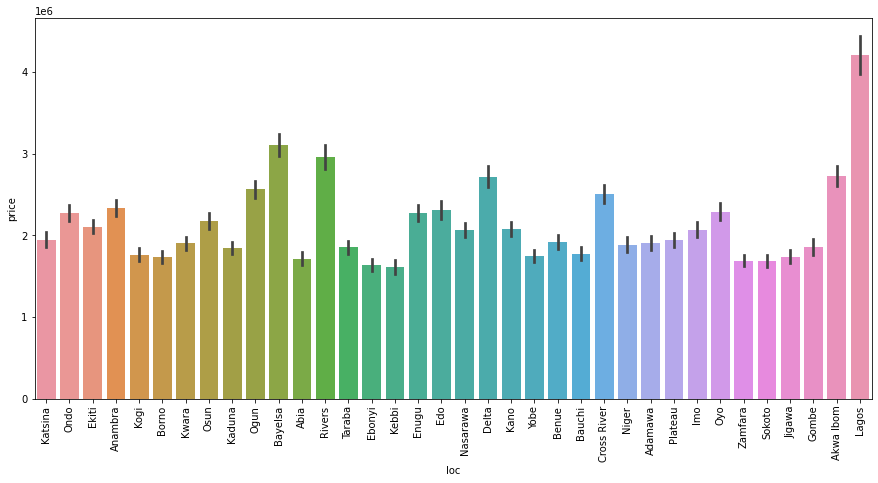

In [13]:
# Visualizing 'location column so see if it has effect on the target'

plt.figure(figsize=(15,7))
sns.barplot(x = train['loc'],y = train['price'])
plt.xticks(rotation = 'vertical')
plt.show()

In [14]:
# Concatenate the Dataset to work on it together

df = pd.concat([train, test]).reset_index(drop = True)
assert (test.shape[0] + train.shape[0]) == df.shape[0]

In [15]:
#Id is just an identity number to the houses , so it'dopped.

df.drop("ID", axis=1, inplace=True)

df.shape

(20000, 6)

In [16]:
#Checking the data types

df.dtypes

loc               object
title             object
bedroom          float64
bathroom         float64
parking_space    float64
price            float64
dtype: object

### Label Encoding

In [17]:
features = [feat for feat in list(df) if feat != 'price' ]
cat_feat = np.where(df[features].dtypes == object)[0]
to_encode = [val for index, val in enumerate(features) if index in cat_feat]

df[to_encode] = df[to_encode].apply(LabelEncoder().fit_transform)

##### Dataset Separation

In [18]:
new_test = df[train.shape[0]:].reset_index(drop = True)
new_train = df[:train.shape[0]]

### Data Splitting Feature and Target

In [19]:
X = new_train.drop("price", axis = 1)
y = new_train['price']

##### Create a function to build the model and evaluate 

In [20]:
def modelling_tree(algorithm,yy,X, test_df):
    cv_score=[]
    test_pred=[]
    
    for train_index, test_index in fold.split(X,pd.Series(yy)):
        
        X_trainx, X_val = X.iloc[train_index], X.iloc[test_index]
        y_trainx, y_val = pd.Series(yy).iloc[train_index], pd.Series(yy).iloc[test_index]

        algorithm.fit(X_trainx,y_trainx)
        
        val_preds=algorithm.predict(X_val)
        cv_score.append(np.sqrt(mean_squared_error(y_val, val_preds)))

        test_p = algorithm.predict(test_df)
        test_pred.append(test_p)
        
    print(f'Validation RMSE Score{np.mean(cv_score)}')

    return np.mean(test_pred, axis = 0)

In [21]:
cat_pred = modelling_tree(algorithm=CatBoostRegressor(silent = True), yy = y , X = X , test_df=new_test[X.columns])

Validation RMSE Score540391.8684952522


In [ ]:
##### Create a submission file

# # Create a submission file
sub_file = submission.copy()
sub_file['price'] = cat_pred

In [23]:
# Write to csv file to submit to Zindi
sub_file.to_csv("Finalrun1.csv", index = False)

In [24]:
sub_file.head()

,ID,price
0,845,2300467.35241
1,1924,995553.26902
2,10718,1170337.45592
3,12076,8334190.69661
4,12254,1840634.46195
